# Simulation

Wind speed -> Power -> H2

In [1]:
import torch
import numpy as np
import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from electrolyzer import run_electrolyzer

from REStats.utils import load_SCADA, filter_outliers, downsample, standardize
from REStats.models import wind_speed, wind_dir, power_curve
from REStats.plots import save_figs

In [2]:
sns.set_theme()

In [3]:
figs = {}
SAVE_FIGS = True

In [4]:
wt_18 = load_SCADA(2018)
wt_19 = load_SCADA(2019)

## Train + Generate Wind Forecast

In [5]:
fcast_train_raw = wt_19[(wt_19.index >= "2019-02-01") & (wt_19.index < "2019-03-01")].copy()
test_raw = wt_19[(wt_19.index >= "2019-03-01") & (wt_19.index < "2019-04-01")].copy()

fcast_train = downsample(fcast_train_raw)
test = downsample(test_raw)

In [6]:
ws_fcast, _ = wind_speed.backtest(fcast_train, test)
wd_fcast, _ = wind_dir.backtest(fcast_train.wind_dir, test.wind_dir)

/home/cam/workspace/projects/REStats/env/lib/python3.10/site-packages/pyro/infer/mcmc/api.py:497: UserWarning: num_chains=2 is more than available_cpu=1. Chains will be drawn sequentially.
  warnings.warn(
Sample [0]: 100%|█| 1500/1500 [00:17, 86.67it/s, step size=9.78e-01, acc. prob=0
Sample [1]: 100%|█| 1500/1500 [00:22, 66.22it/s, step size=7.43e-01, acc. prob=0



Results for step size: 1
RMSE: 1.1151290075591727 m/s
RMSE (%): 14.831744776450307
MAE: 0.8308615842380371 m/s

Results for step size: 1
RMSE: 13.061025683919441 deg
RMSE (%): 5.177758137171221
MAE: 8.31774552209911 deg


## Train + Predict Power Curve

In [7]:
pc_train_raw = pd.concat([wt_18, fcast_train])
cut_in = 2.0
cut_out = 18.0
pc_filtered = filter_outliers(pc_train_raw)
pc_train = downsample(pc_filtered)
pc_train = pc_train[(pc_train.wind_speed >= cut_in) & (pc_train.wind_speed < cut_out)]

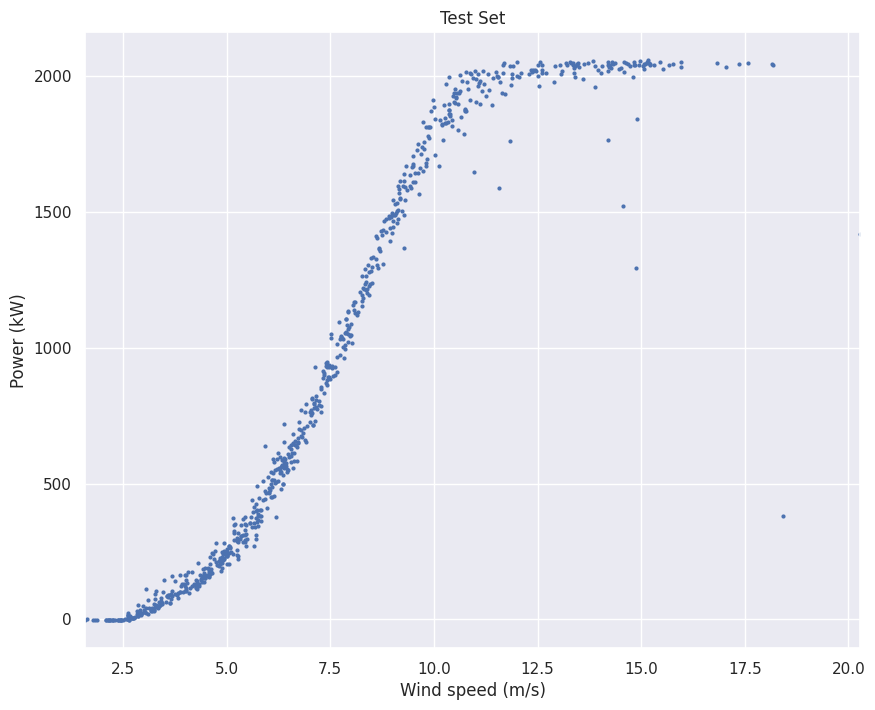

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.set_xmargin(0)
ax.set_title("Test Set")
ax.set_xlabel("Wind speed (m/s)")
ax.set_ylabel("Power (kW)")
ax.scatter(test.wind_speed, test.power, s=4)

figs["sim_test_set"] = fig

### Wind only

In [9]:
kbd = KBinsDiscretizer(n_bins=20, encode="ordinal")
bins = kbd.fit_transform(pc_train.wind_speed.to_numpy()[:, None])

pc_train, _ = train_test_split(pc_train, stratify=bins, train_size=800, random_state=1)

In [ ]:
train_std = standardize(pc_train)

X_train = torch.tensor(train_std.wind_speed)
y_train = torch.tensor(train_std.power)

model, likelihood = power_curve.fit(X_train, y_train)

Iter 1/100 - Loss: 0.768   lengthscale: [[0.6931471824645996]]   noise: 0.693
Iter 2/100 - Loss: 0.731   lengthscale: [[0.7443966269493103]]   noise: 0.644
Iter 3/100 - Loss: 0.693   lengthscale: [[0.7979333400726318]]   noise: 0.598
Iter 4/100 - Loss: 0.654   lengthscale: [[0.8535958528518677]]   noise: 0.554
Iter 5/100 - Loss: 0.615   lengthscale: [[0.9112037420272827]]   noise: 0.513
Iter 6/100 - Loss: 0.575   lengthscale: [[0.9705477952957153]]   noise: 0.474
Iter 7/100 - Loss: 0.535   lengthscale: [[1.0313762426376343]]   noise: 0.437
Iter 8/100 - Loss: 0.494   lengthscale: [[1.0933847427368164]]   noise: 0.403
Iter 9/100 - Loss: 0.453   lengthscale: [[1.156213641166687]]   noise: 0.370
Iter 10/100 - Loss: 0.411   lengthscale: [[1.2194527387619019]]   noise: 0.340
Iter 11/100 - Loss: 0.369   lengthscale: [[1.282645344734192]]   noise: 0.312
Iter 12/100 - Loss: 0.326   lengthscale: [[1.345289707183838]]   noise: 0.286
Iter 13/100 - Loss: 0.282   lengthscale: [[1.4068354368209839]] 

In [ ]:
test_sort = test.sort_values("wind_speed")
test_sort_std = standardize(test_sort, ref_df=pc_train)
X_test_torch = torch.tensor(test_sort_std.wind_speed)

test_pred = power_curve.predict(model, likelihood, X_test_torch)

When we assume a perfect wind forecast,

In [ ]:
test_pred_tf = test_pred.mean.numpy() * pc_train.power.std() + pc_train.power.mean()
test_rmse = mean_squared_error(test_pred_tf, test_sort.power, squared=False)
test_rmse_rel = test_rmse / test_sort.power.mean() * 100
test_mae = mean_absolute_error(test_pred_tf, test_sort.power)

print(f"Test RMSE: {test_rmse} kW")
print(f"Test RMSE (%): {test_rmse_rel}")
print(f"Test MAE: {test_mae} kW")

When we use the real wind forecast,

In [ ]:
fcast = ws_fcast["mean"]
fcast_std = (fcast - pc_train.wind_speed.mean())/pc_train.wind_speed.std()
fcast_torch = torch.tensor(fcast_std)

test_pred = power_curve.predict(model, likelihood, fcast_torch)

test_pred_tf = test_pred.mean.numpy() * pc_train.power.std() + pc_train.power.mean()

# filter out values outside operating range
pred_filtered = np.zeros(len(test_pred_tf))

for i, pred in enumerate(fcast):
    if (pred < cut_in) or (pred >= cut_out):
        pred_filtered[i] = 0.0
    else:
        pred_filtered[i] = test_pred_tf[i]


test_rmse = mean_squared_error(pred_filtered, test.power, squared=False)
test_rmse_rel = test_rmse / test.power.mean() * 100
test_mae = mean_absolute_error(pred_filtered, test.power)
print(f"Test RMSE: {test_rmse} kW")
print(f"Test RMSE (%): {test_rmse_rel}")
print(f"Test MAE: {test_mae} kW")

In [ ]:
with torch.no_grad():
    
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.set_xmargin(0)
    ax.set_title("Power predictions (test set)")
    ax.set_ylabel("Power (kW)")
    
    # Plot test data
    ax.plot(test.index, test.power)
    # Plot predictive means
    ax.plot(test.index, test_pred_tf)

    ax.legend(['Observed Data', 'Mean'])
    
figs["power_fcast"] = f

In [ ]:
test.sort_values("wind_speed")

In [ ]:
with torch.no_grad():    
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.set_xmargin(0)
    ax.set_title("Power predictions (test set)")
    ax.set_ylabel("Power (kW)")
    
    # Get upper and lower confidence bounds
    lower, upper = test_pred.confidence_region()
    
    res_df = test.copy()
    res_df["lower"] = lower.numpy() * pc_train.power.std() + pc_train.power.mean()
    res_df["upper"] = upper.numpy() * pc_train.power.std() + pc_train.power.mean()
    res_df["pred"] = test_pred_tf
    
    t = res_df[(res_df.index >= "2019-03-13") & (res_df.index < "2019-03-20")]
    
    # Plot test data
    ax.plot(t.index, t.power)
    # Plot predictive means
    ax.plot(t.index, t.pred)
    # Shade between the lower and upper confidence bounds
    ax.fill_between(t.index, t.lower, t.upper, color="C1", alpha=0.5)
    ax.legend(['Observed Data', 'Mean', 'Confidence (2$\sigma$)'])
    
figs["sim_power_fcast"] = f

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xmargin(0)
ax.set_title("Wind speeds (test set)")
ax.set_ylabel("Wind speed (m/s)")

ax.plot(t.index, t.wind_speed)

figs["sim_ws_test_set"] = fig

### Full inputs

In [ ]:
forecasts = pd.DataFrame({"wind_dir": wd_fcast["mean"], "wind_speed": ws_fcast["mean"]}, index=ws_fcast.index)
forecasts

In [ ]:
forecasts_std = standardize(forecasts, ref_df=pc_train)

In [ ]:
X_test2 = torch.tensor(forecasts_std[["wind_speed", "wind_dir"]].values, dtype=torch.float32)

X_train2 = torch.tensor(train_std[["wind_speed", "wind_dir"]].values, dtype=torch.float32)
y_train2 = torch.tensor(train_std.power, dtype=torch.float32)

model2, likelihood2 = power_curve.fit(X_train2, y_train2, dims=2)
test_pred2 = power_curve.predict(model2, likelihood2, X_test2)

Assuming a perfect forecast,

In [ ]:
X_test_torch2 = torch.tensor(test_sort_std[["wind_speed", "wind_dir"]].values, dtype=torch.float32)

test_pred_p = power_curve.predict(model2, likelihood2, X_test_torch2)

test_pred_p_tf = test_pred_p.mean.numpy() * pc_train.power.std() + pc_train.power.mean()
test_rmse_p = mean_squared_error(test_pred_p_tf, test_sort.power, squared=False)
test_rmse_p_rel = test_rmse_p / test.power.mean() * 100
test_mae_p = mean_absolute_error(test_pred_p_tf, test_sort.power)

print(f"Test RMSE: {test_rmse_p} kW")
print(f"Test RMSE (%): {test_rmse_p_rel}")
print(f"Test MAE: {test_mae_p} kW")

When we use the real wind forecast,

In [ ]:
test_pred_tf2 = test_pred2.mean.numpy() * pc_train.power.std() + pc_train.power.mean()

# filter out values outside operating range
pred_filtered2 = np.zeros(len(test_pred_tf2))

for i, pred in enumerate(forecasts.wind_speed):
    if (pred < cut_in) or (pred >= cut_out):
        pred_filtered2[i] = 0.0
    else:
        pred_filtered2[i] = test_pred_tf2[i]


test_rmse2 = mean_squared_error(pred_filtered2, test.power, squared=False)
test_rmse2_rel = test_rmse2 / test.power.mean() * 100
test_mae2 = mean_absolute_error(pred_filtered2, test.power)
print(f"Test RMSE: {test_rmse2} kW")
print(f"Test RMSE (%): {test_rmse2_rel}")
print(f"Test MAE: {test_mae2} kW")

In [ ]:
modeling_options = "../sim/modeling_options.yaml"
_, h2_prod = run_electrolyzer(modeling_options, test.power.values * 1e3)

_, h2_prod_fcast = run_electrolyzer(modeling_options, pred_filtered * 1e3)

h2_prod

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xmargin(0)
ax.set_title("Electrolyzer Stack Cycles")
ax.set_ylabel("Cycles")

cycles = [c for c in h2_prod.columns if "cycles" in c]
cycles_df = h2_prod[cycles]
cycles_df_fcast = h2_prod_fcast[cycles]

labels_obs = [f"Stack {i+1} (obs)" for i in range(len(cycles))]
labels_fcast = [f"Stack {i+1} (forecast)" for i in range(len(cycles))]

ax.plot(test.index, cycles_df, "--", label=labels_obs)
ax.plot(test.index, cycles_df_fcast, label=labels_fcast)
ax.legend()

figs["h2_cycles"] = fig

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xmargin(0)

ax.set_title("$H_2$ Production Rate")
ax.set_ylabel("$H_2$ Produced (kg/hr)")
ax.plot(test.index, h2_prod.kg_rate, label="Actual")
ax.plot(test.index, h2_prod_fcast.kg_rate, label="Forecast")

ax.legend()

figs["sim_h2_fcast"] = fig

In [ ]:
h2_rmse = mean_squared_error(h2_prod.kg_rate.values, h2_prod_fcast.kg_rate.values, squared=False)
h2_rmse_rel = h2_rmse / h2_prod.kg_rate.values.mean() * 100
h2_mae = mean_absolute_error(h2_prod.kg_rate.values, h2_prod_fcast.kg_rate.values)

print(f"Mean H2 production rate: {h2_prod.kg_rate.mean()} kg/hr\n")
print(f"H2 Forecast RMSE: {h2_rmse} kg/hr")
print(f"H2 Forecast RMSE (%): {h2_rmse_rel}")
print(f"H2 Forecast MAE: {h2_mae} kg/hr\n")

h2_total = h2_prod.kg_rate.sum()
h2_fcast_total = h2_prod_fcast.kg_rate.sum()

print(f"Total H2 production: {h2_total} kg")
print(f"Total forecasted H2 production: {h2_fcast_total} kg")

In [ ]:
_, h2_prod_fcast2 = run_electrolyzer(modeling_options, pred_filtered2 * 1e3)

In [ ]:
h2_rmse = mean_squared_error(h2_prod.kg_rate.values, h2_prod_fcast2.kg_rate.values, squared=False)
h2_rmse_rel = h2_rmse / h2_prod.kg_rate.values.mean() * 100
h2_mae = mean_absolute_error(h2_prod.kg_rate.values, h2_prod_fcast2.kg_rate.values)

print(f"Mean H2 production rate: {h2_prod.kg_rate.mean()} kg/hr\n")
print(f"H2 Forecast RMSE: {h2_rmse} kg/hr")
print(f"H2 Forecast RMSE (%): {h2_rmse_rel}")
print(f"H2 Forecast MAE: {h2_mae} kg/hr\n")

h2_total = h2_prod.kg_rate.sum()
h2_fcast_total = h2_prod_fcast2.kg_rate.sum()

print(f"Total H2 production: {h2_total} kg")
print(f"Total forecasted H2 production: {h2_fcast_total} kg")

### Investigation: filtering outliers

What if we don't have outliers? How will that affect the overall result?

In [ ]:
p_full = test.copy()
p_full["fcast"] = pred_filtered2
p_fil = filter_outliers(p_full)
p_fil = p_fil[(p_fil.wind_speed >= cut_in) & (p_fil.wind_speed < cut_out)]

test_rmse2_fix = mean_squared_error(p_fil.fcast, p_fil.power, squared=False)
test_rmse2_fix_rel = test_rmse2_fix / p_fil.power.mean() * 100
test_mae2_fix = mean_absolute_error(p_fil.fcast, p_fil.power)
print(f"Test RMSE: {test_rmse2_fix} kW")
print(f"Test RMSE (%): {test_rmse2_fix_rel}")
print(f"Test MAE: {test_mae2_fix} kW")

_, h2_prod_fil = run_electrolyzer(modeling_options, p_fil.power.values * 1e3)

_, h2_prod_fil_fcast = run_electrolyzer(modeling_options, p_fil.fcast.values * 1e3)

h2_rmse_fil = mean_squared_error(h2_prod.kg_rate.values, h2_prod_fcast.kg_rate.values, squared=False)
h2_rmse_rel_fil = h2_rmse / h2_prod.kg_rate.values.mean() * 100
h2_mae_fil = mean_absolute_error(h2_prod.kg_rate.values, h2_prod_fcast.kg_rate.values)

print(f"Mean H2 production rate: {h2_prod_fil.kg_rate.mean()} kg/hr\n")
print(f"H2 Forecast RMSE: {h2_rmse_fil} kg/hr")
print(f"H2 Forecast RMSE (%): {h2_rmse_rel_fil}")
print(f"H2 Forecast MAE: {h2_mae_fil} kg/hr\n")

h2_total_fil = h2_prod_fil.kg_rate.sum()
h2_fcast_total_fil = h2_prod_fil_fcast.kg_rate.sum()

print(f"Total H2 production: {h2_total_fil} kg")
print(f"Total forecasted H2 production: {h2_fcast_total_fil} kg")

In [ ]:
print("Full set", len(test))
n_fil = len(p_full) - len(p_fil)
print("Outlier points", n_fil)
print("Outlier %", n_fil/len(test))

In [ ]:
if SAVE_FIGS:
    save_figs(figs, format="svg")